# ODAY ​NAJAD (Matricola N. 2107495)
## Jan 28, 2024

# Implementation of a combination of supervised, unsupervised, and self supervised learning

## Introduction

We have seen that supervised, unsupervised, and self-supervised have advantages and disadvantages. We also have encountered one of the challenges associated with NN is noise, and we utilized unsupervised learning to address this problem.
To summarize:
 - Supervised has the advantage of being "direct" and simpler, but labeling data is costly. 
- Unsupervised has the advantage of being cheaper, but the most we can do is cluster and learn hidden variables (which also includes denoising).

Self-Supervised; I consider it highly intriguing, because it contains the advantages of the two models:
 - Can learn certain tasks based on a goal value. 
- Does not require labeled data.

As a disadvantage, it fails to have numerous uses, because when training it, the target is usually either the data itself, or some transformation of it.

Let's get started and  apply this thinking to neural networks.  

The difficulty with Neural Networks is that the more information we have, the easier it is to identify a classifier that works well.  
For example, a basic Perceptron or Logistic regressor with a linear decision boundary benefits from additional features, because the more dimensions we have, the easier it is to linearly divide the data (typically).

The disadvantage is that the density of data in the space where it is placed has an inverse correlation to its dimensions: the more features we have, the sparser the data is.

From a cognitive standpoint, we are unable to address this problem with algorithms, because I am skeptical that evolution enabled the human brain to develop PCA as we know it, but there has to be an aspect that allows our mind to minimize the complexity/dimensionality of the information that it acquires in a "natural" manner.

We will do this through self-supervised learning. In particular, we will take advantage of the notion that we can constrain the amount of neurons in our neural network to a specific number, allowing us to "force" the NN to transition from $N$ dimensional space to $N/2$ dimensions (for example), decreasing the dimensionality issue.

However, in order for us to demonstrate this in a supervised setting, we must also convert the data into this new compact dimension.  
To circumvent this issue, we will attempt to train the NN to rebuild the picture from a smaller dimension, with the input data serving as the target.

Let's employ auto-encoders to "eliminate" part of the problem's dimensionality.

Following that, we'll examine whether this method can assist our NN categorize the test set and perhaps ignore/remove noise by experimenting with two approaches:

 1. Self-supervised $\rightarrow$ Supervised
 2. Self-supervised $\rightarrow$ Unsupervised $\rightarrow$ Supervised

This is due to the fact that if the self-supervised part has the ability to decrease the noise, and the unsupervised part is capable to retrieve hidden characteristics from the image that was reconstructed, the end result perceptron should be nearly impermeable (in the context of "small noise" to the noise itself), thus, as presented in the the lab, be considered nearly as effective as a FeedForward neural network.


So here's the finished models:
- AutoEncoder + DBN + Perceptron (trained in one-vs-all):
   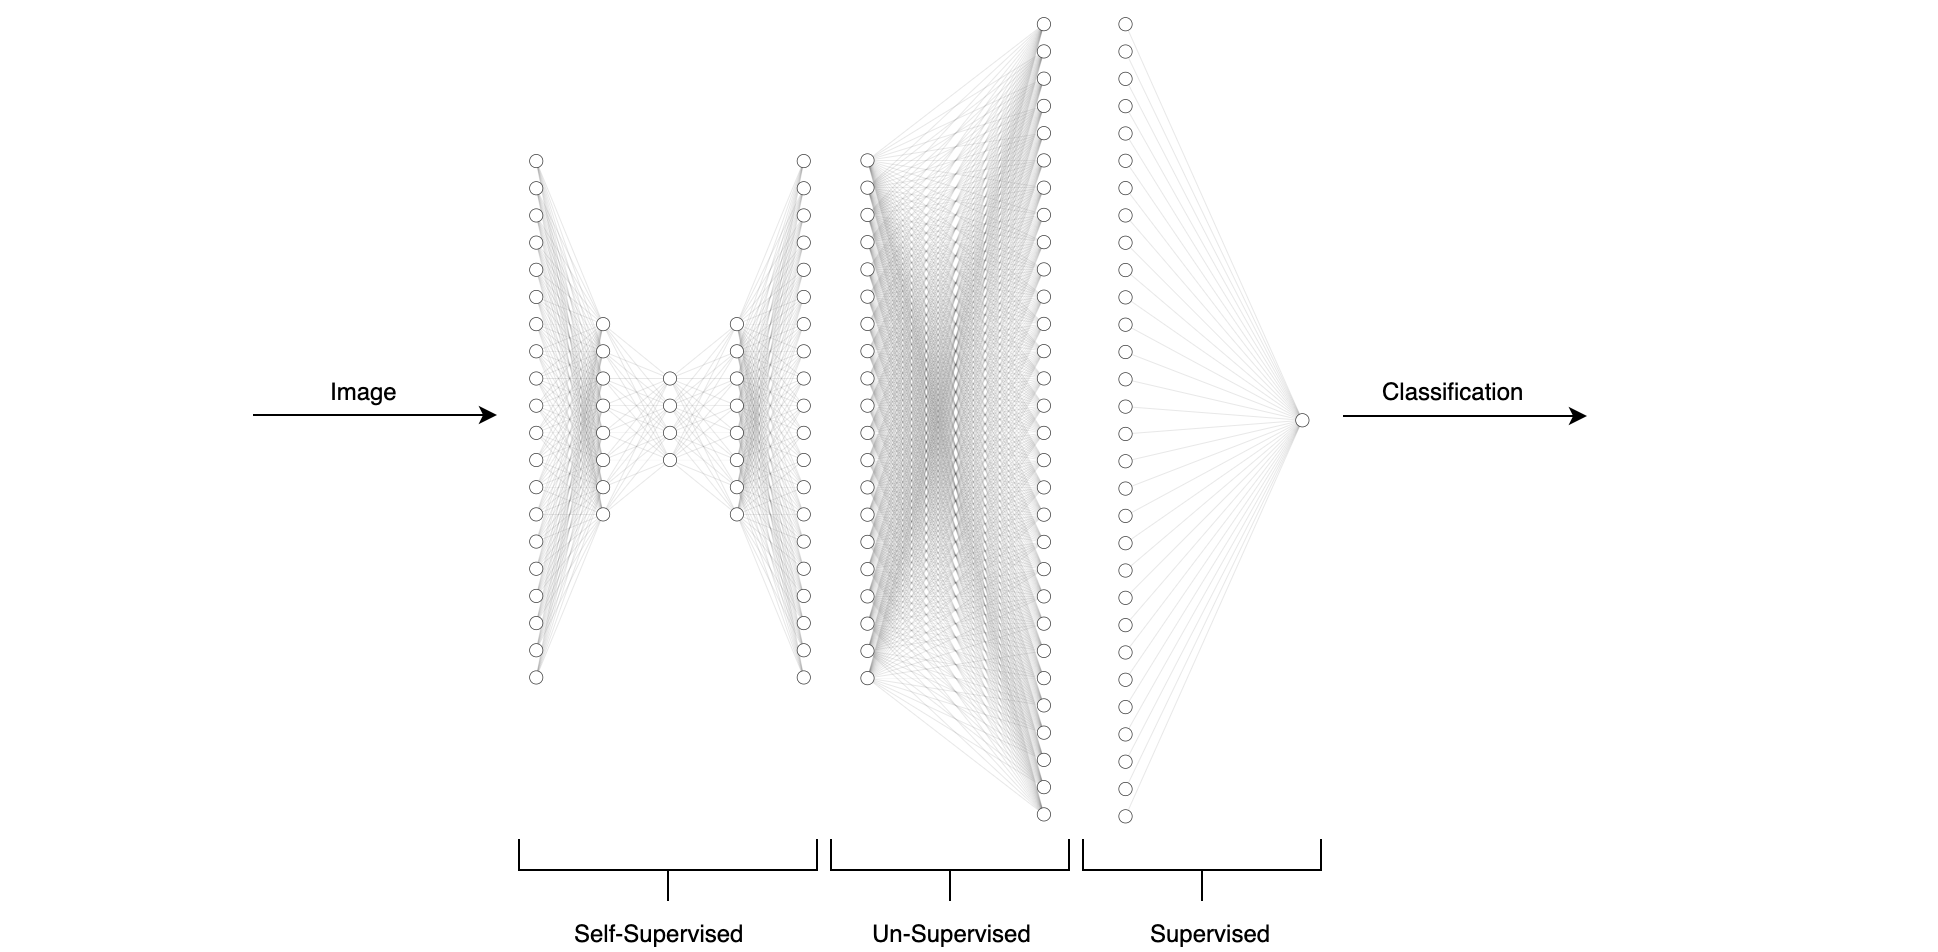
 - AutoEcnoder + NN:
   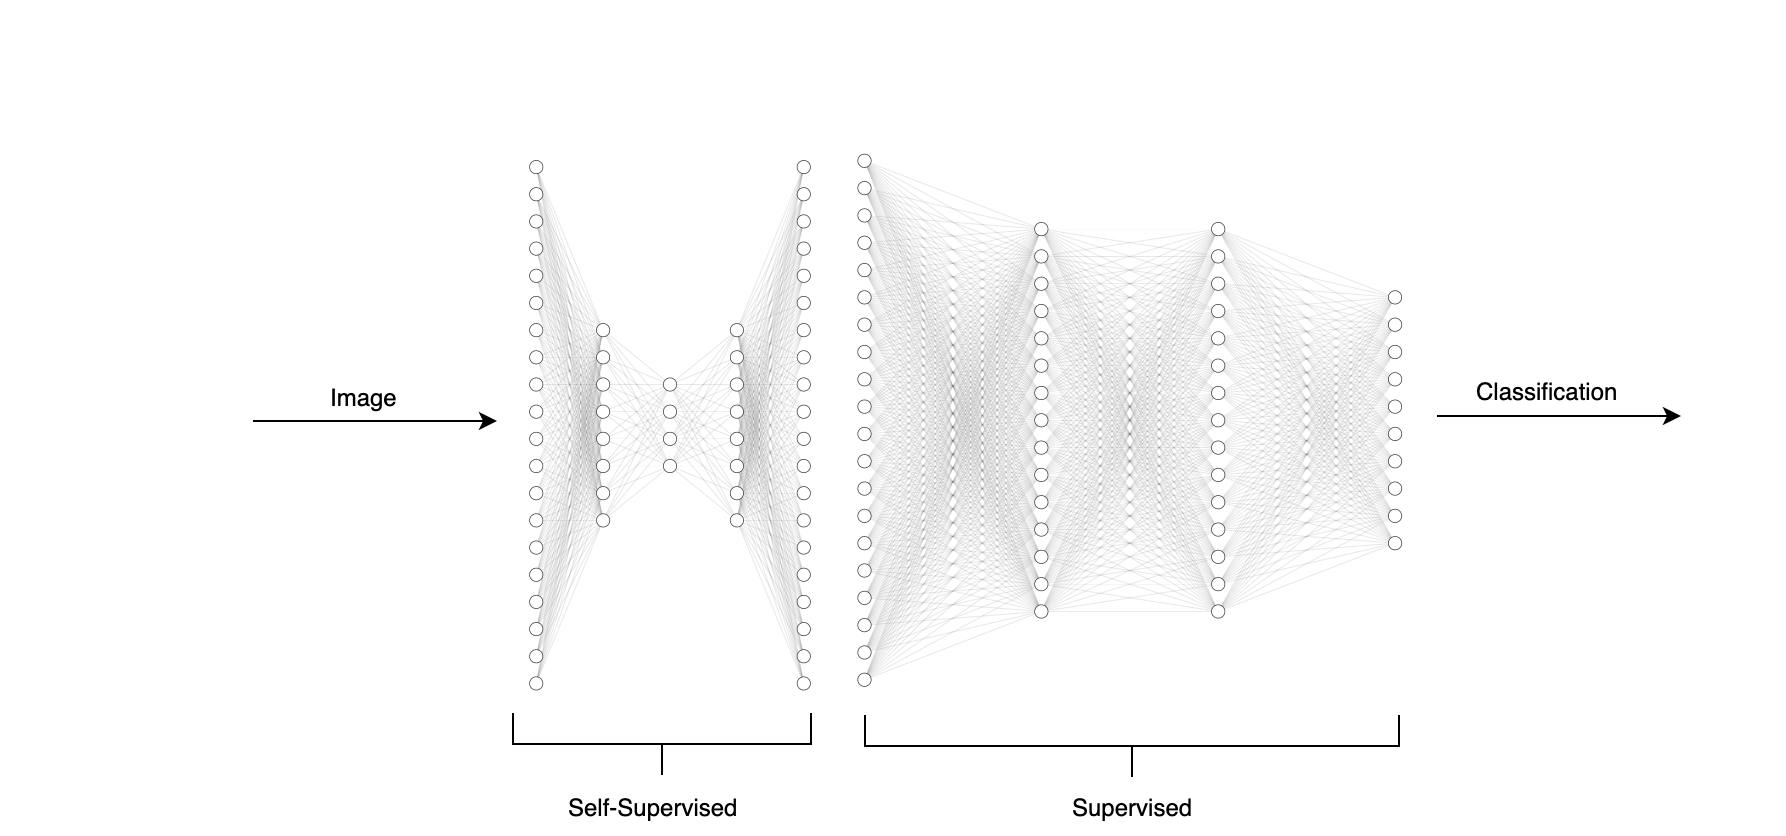

## Preparation

To assist manage the models, we will use a helper function and 'pickle' to save the models as files and preserve them on the mounted Google Drive (thereby copying the serializations on the current folder).

In [97]:
import pickle
# get the serialized object, or get a default value
def getFromFileOrDefault(filename, callback):
  try:
    return pickle.load(open(filename, "rb"))
  except (OSError, IOError) as e:
    print("exception thrown")
    print(e)
    obj = callback()
    with open(filename, 'wb') as handle:
      pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return obj

In [98]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/CC/Models/* ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing dataset

First things first: import the data.

We will utilize the Mnist digits dataset, which consists of 28*28-pixel pictures and 10 classes.

To assist evaluate our models, we will take the first $10.000$ samples as a test set and the remainder as a training set.

In [99]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
mnist_data = tv.datasets.MNIST('data/', train=True, download=True,
                                        transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor(),
                                             tv.transforms.Normalize((0.1307,), (0.3081,))]
                                        ))
mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255)

mnist_data_train = mnist_data.data[10000:, :]
mnist_targets_train = mnist_data.targets[10000:]

mnist_data_test = mnist_data.data[:10000, :]
mnist_targets_test = mnist_data.targets[:10000]

Now visualize the data:

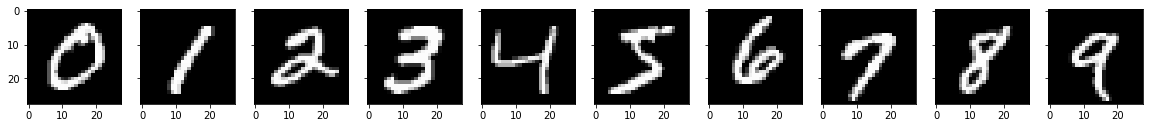

In [100]:
classes = set(mnist_data.targets.numpy())
examples = [mnist_data.data[np.where(mnist_data.targets == c)[0][0]] for c in classes]

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 20))
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

Below are the distribution of the classes on the test and training set

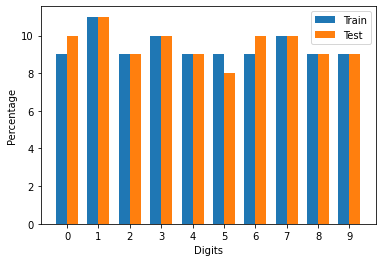

In [101]:
import matplotlib.pyplot as plt
import numpy as np



x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [int(sum(mnist_targets_train.numpy() == i) / len(mnist_targets_train) * 100) for i in classes], width, label='Train')
rects2 = ax.bar(x + width/2, [int(sum(mnist_targets_test.numpy() == i) / len(mnist_targets_test) * 100) for i in classes], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_xlabel('Digits')

ax.legend()
plt.xticks([i for i in classes])
plt.show()

## Building the self supervised model (autoencoder)

### Dense NN

Starting from a very straightforward model, with a single layer for encoding and a single layer for decoding

In [102]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
encoding_dim = 32  # 32 floats -> compression of factor 24.5 with input 784 floats

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 8, 
                        verbose=1)

def train_autoencoder_one_layer():
  data_trans = np.reshape(mnist_data_train.numpy(), (len(mnist_data_train.numpy()), 784))
  autoencoder.fit(data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder
autoencoder = getFromFileOrDefault('autoencoder_one_layer', train_autoencoder_one_layer)

After the training (~ 7 minutes), validate the reconstruction of the former examples:

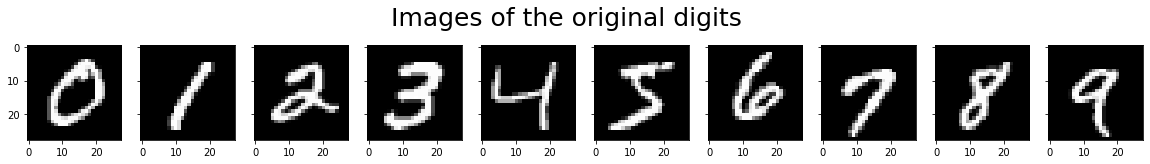

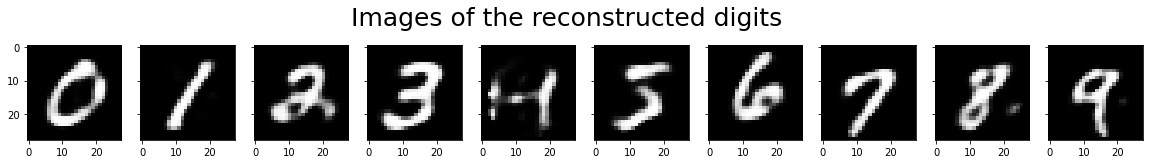

In [103]:

examples_predicted = autoencoder.predict(np.reshape([e.numpy() for e in examples], (len(examples), 784)))

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the original digits', fontsize=25, y=1.1)

for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)


num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the reconstructed digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)

As we can see, it reconstructs the pictures in a "clear way," but the loss remains substantial, suggesting that one layer is insufficient... Let's add additional layers to make the model a little more strong.

In [104]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
autoencoder_complex = Sequential([
    Input(shape=(784,)),
    Dense(units=80 , activation='relu'),
    Dense(units=encoding_dim , activation='relu'),
    Dense(units=80 , activation='relu'),
    Dense(784, activation='sigmoid')
])
autoencoder_complex.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 4, 
                        verbose=1)


def train_autoencoder_complex():
  data_trans = np.reshape(mnist_data_train.numpy(), (len(mnist_data_train.numpy()), 784))
  autoencoder_complex.fit(data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_complex

autoencoder_complex = getFromFileOrDefault('autoencoder_complex', train_autoencoder_complex)

After around 9 minutes, it should be finished, and we can immediately see that the loss during training is somewhat reduced (0.0863 instead of 0.0941). Let's look at some samples.


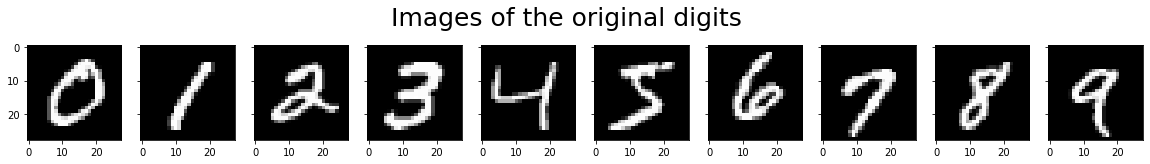

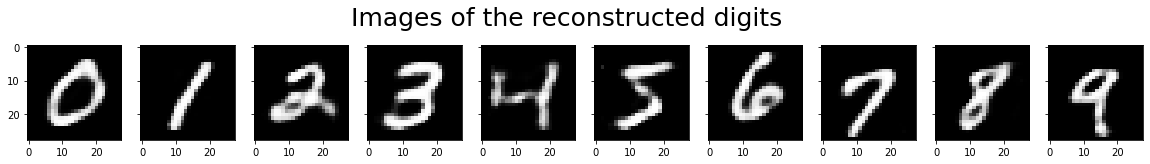

In [105]:

examples_predicted = autoencoder_complex.predict(np.reshape([e.numpy() for e in examples], (len(examples), 784)))

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the original digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the reconstructed digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)

The improvement is evident, particularly on the number 4, which was before virtually a H and now resembles a true 4.

However, the goal of this "sub-network" is not to reconstruct pictures, but to remove noise, so we may train the network on the noised data, to see if it can learn how to remove noise.

Let's try to train the autoencoder on perturbed data... to achieve this, we'll insert some noise into the training data and retrain the model from the ground up.

In [106]:
import torch
def _inject_noise(data, noise_level):
  torch.manual_seed(0)
  random_gaussian_tensor = torch.randn(data.shape)/6.6 + .6
  probability_tensor = torch.ones(data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return data - mask_tensor * data + mask_tensor * random_gaussian_tensor

noised_mnist_data_train = _inject_noise(mnist_data_train, 0.3)
noised_mnist_data_test = _inject_noise(mnist_data_test, 0.3)

In [107]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
# This is the size of our encoded representations
encoding_dim = 32  
autoencoder_complex_noised = Sequential([
    Input(shape=(784,)),
    Dense(units=80 , activation='relu'),
    Dense(units=encoding_dim , activation='relu'),
    Dense(units=80 , activation='relu'),
    Dense(784, activation='sigmoid')
])
autoencoder_complex_noised.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 8, 
                        verbose=1)


def train_autoencoder_complex_noised(): 
  noised_data_trans = np.reshape(noised_mnist_data_train.numpy(), (len(noised_mnist_data_train.numpy()), 784))
  data_trans = np.reshape(mnist_data_train.numpy(), (len(mnist_data_train.numpy()), 784))
  autoencoder_complex_noised.fit(noised_data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_complex_noised

autoencoder_complex_noised = getFromFileOrDefault('autoencoder_complex_noised', train_autoencoder_complex_noised)

Let's now look at this autoencoder trained on noisy data, what it can predict, and how much noise it can remove.

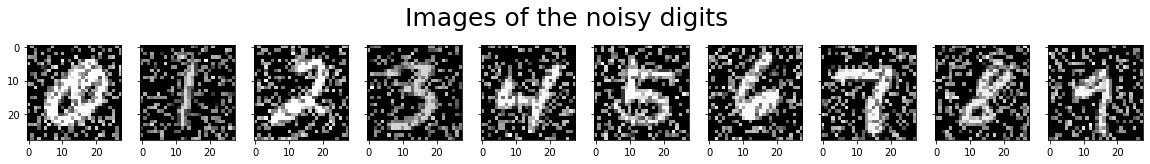

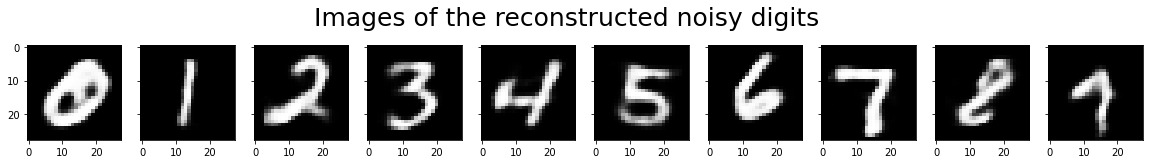

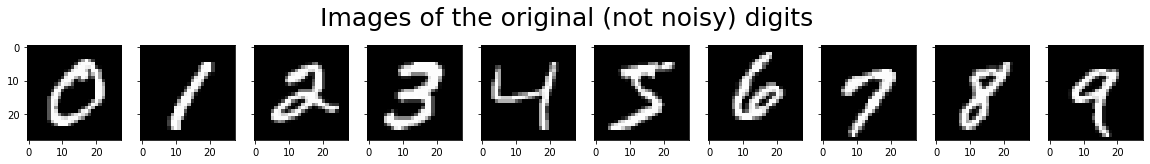

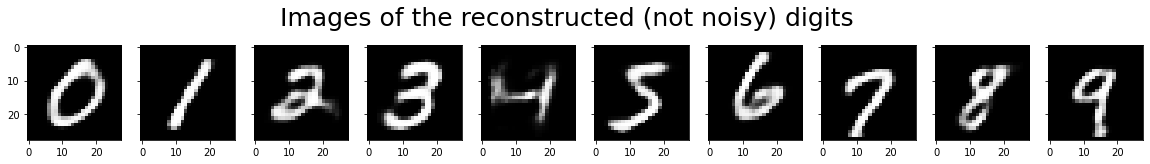

In [108]:
noised_examples = np.array([
      np.reshape(noised_mnist_data_train.numpy(), (len(noised_mnist_data_train.numpy()), 784))[
         np.where(mnist_targets_train == c)[0][0]
      ] for c in classes])
noised_examples = np.reshape(noised_examples, (len(noised_examples), 784))
examples_predicted = autoencoder_complex_noised.predict(noised_examples)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the noisy digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the reconstructed noisy digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)





num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the original (not noisy) digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

examples_predicted = autoencoder_complex_noised.predict(np.reshape(np.array([e.numpy() for e in examples]), (len(examples_predicted), 784)))
num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the reconstructed (not noisy) digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)



I would argue that the autoencoder's capacity to reduce noise is rather fantastic, and so the decision to train the model on noisy data has been really beneficial.
This also suggests that the model is learning what constitutes noise, rather than just "removing white" pixels. 

### Convolutional NN

To test different models, because we are dealing with photos, why not check if CNN can get higher accuracy:

In [109]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cnn_noised = keras.Model(input_img, decoded)
autoencoder_cnn_noised.compile(optimizer='adam', loss='binary_crossentropy')

es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 4, 
                        verbose=1)

def train_autoencoder_cnn_noised():
  noised_data_trans = noised_mnist_data_train.numpy()
  data_trans = mnist_data_train.numpy()
  autoencoder_cnn_noised.fit(noised_data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_cnn_noised

autoencoder_cnn_noised = getFromFileOrDefault('autoencoder_cnn_noised', train_autoencoder_cnn_noised)

We can immediately see that the loss is about the same, so we don't expect much difference... yet the training took 52 minutes, compared to the less than 18 of the prior model.

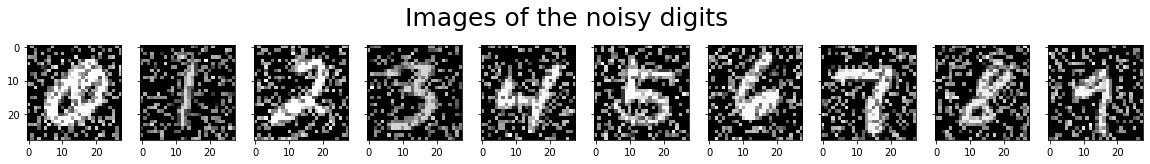

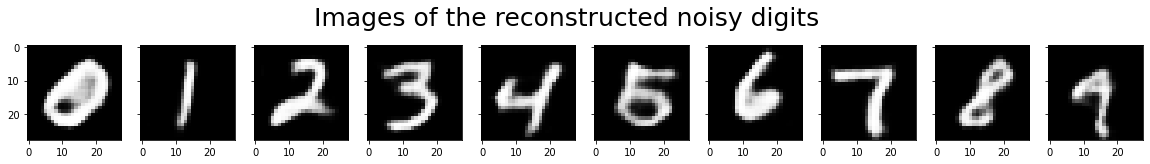

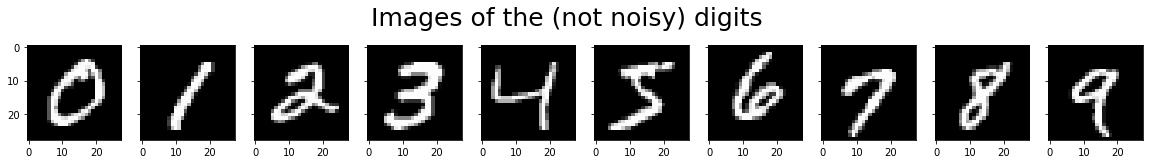

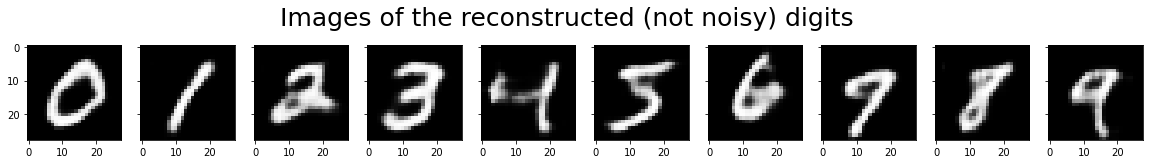

In [110]:
noised_examples = np.array([noised_mnist_data_train.numpy()[np.where(mnist_targets_train == c)[0][0]] for c in classes])
examples_predicted = autoencoder_cnn_noised.predict(noised_examples)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the noisy digits', fontsize=25, y=1.1)

for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the reconstructed noisy digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)




num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the (not noisy) digits', fontsize=25, y=1.1)
for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples[i].reshape((28,28)), cmap=plt.cm.gray)

examples_predicted = autoencoder_cnn_noised.predict(np.array([e.numpy() for e in examples]))

num_subplots = 10
n_rows_cols = 1
fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
fig.suptitle('Images of the reconstructed (not noisy) digits', fontsize=25, y=1.1)

for i in range(num_subplots):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)


Personally, the only difference I perceive is on the 4, but it still works as anticipated.

### Model comparison

Finally, we will compare the two best models to observe how they respond to fresh data (test data), both with and without noisy input.

Prepare the data

In [111]:
# prepare data
classes = set(mnist_data.targets.numpy())
test_examples = np.array([
    mnist_data_test[np.where(mnist_targets_test == c)[0][0]].numpy()
    for c in classes
])
test_noised_examples = np.array([
    noised_mnist_data_test[np.where(mnist_targets_test == c)[0][0]] .numpy()
    for c in classes
])


Check performance on perturbated data

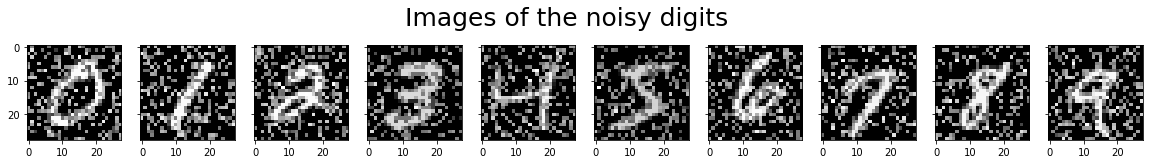

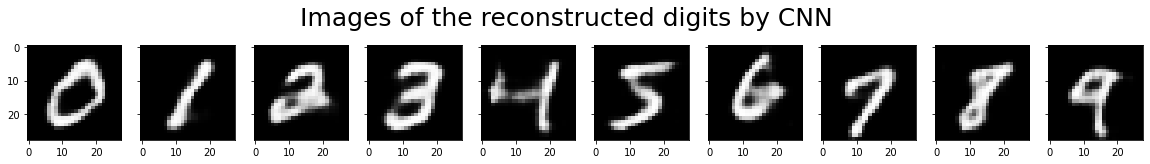

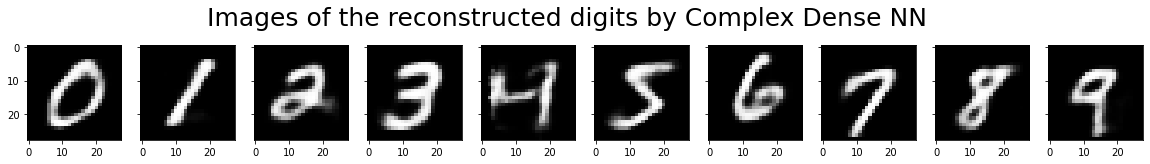

In [112]:
def free():
  test_noised_examples_predicted_cnn = autoencoder_cnn_noised.predict(test_noised_examples)
  test_noised_examples_predicted_complex = autoencoder_complex_noised.predict(np.reshape(test_noised_examples, (len(test_noised_examples), 784)))

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the noisy digits', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits by CNN', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_noised_examples_predicted_cnn[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits by Complex Dense NN', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_noised_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

free()

Performace on original data

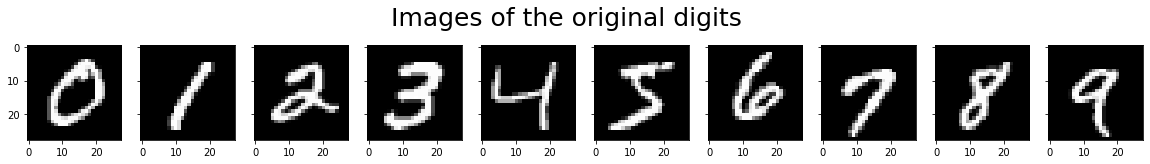

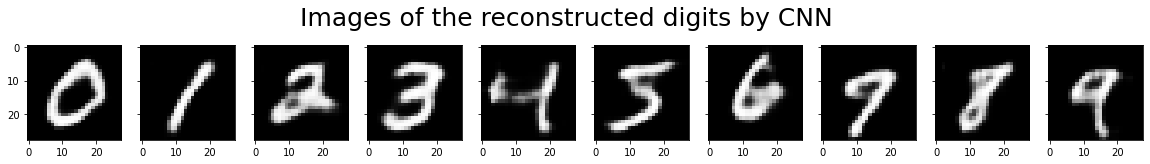

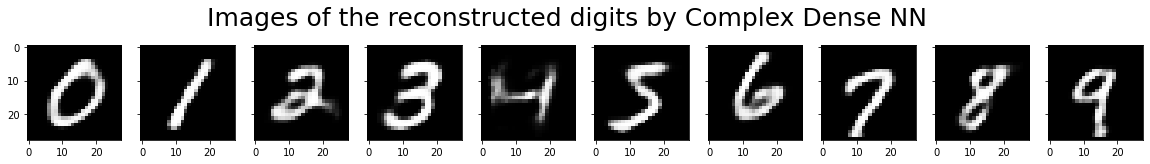

In [113]:
def free():
  test_examples_predicted_cnn = autoencoder_cnn_noised.predict(test_examples)
  test_examples_predicted_complex = autoencoder_complex_noised.predict(np.reshape(test_examples, (len(test_examples), 784)))

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the original digits', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits by CNN', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_predicted_cnn[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits by Complex Dense NN', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

free()

Personally, given those ten data, I would suggest that the "complex" model with three layers is superior to the CNN.

However, I'd want to point out how the models have learned what is noise in a very broad way. For example, if we start with a non-noised element, there is practically no "white" eliminated, indicating that the models grasp what is noise and what is character.

This is even more clear if we take the same model and train one copy with noised data and another copy with non-noised data, and then compare the final result on non-noised data.

We already have such a model (the "complex" one), `autoencoder_complex`, which is a dense NN trained on original data, and `autoencoder_complex_noised`, which is trained on noised data... let's see how they vary.

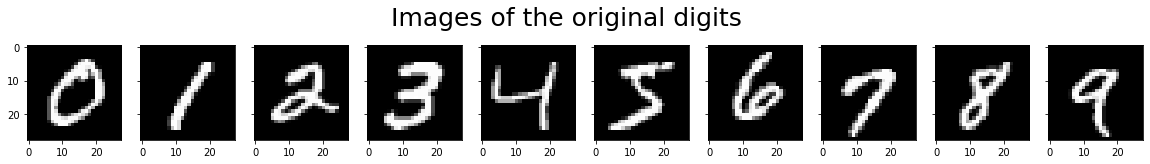

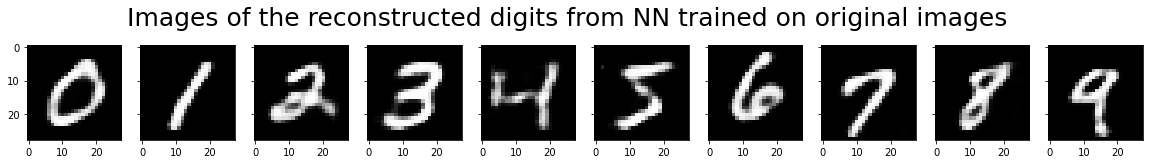

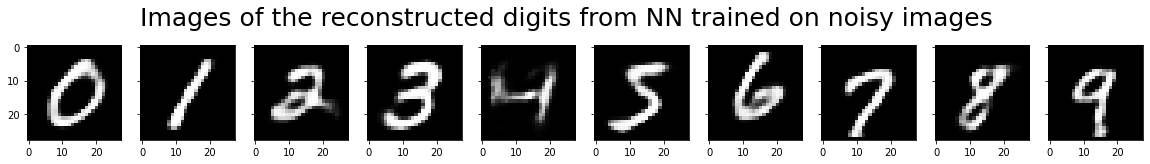

In [114]:
def free():
  #data
  classes = set(mnist_data.targets.numpy())
  test_examples = [mnist_data_test[np.where(mnist_targets_test == c)[0][0]].numpy() for c in classes]
  test_examples = np.reshape(test_examples, (len(test_examples), 784))
  test_examples_predicted_complex = autoencoder_complex.predict(test_examples)
  test_examples_predicted_complex_noised = autoencoder_complex_noised.predict(test_examples)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the original digits', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits from NN trained on original images', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits from NN trained on noisy images', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_predicted_complex_noised[i].reshape((28,28)), cmap=plt.cm.gray)

free()

I believe the model trained on original data (second line of photos) and the model trained exclusively on perturbed images (third line of images) are almost identical.

The major difference is revealed when we do the inverse, and test the "complex" models on noisy data to observe how much worse the model trained on original data performs than the one trained on perturbed data.


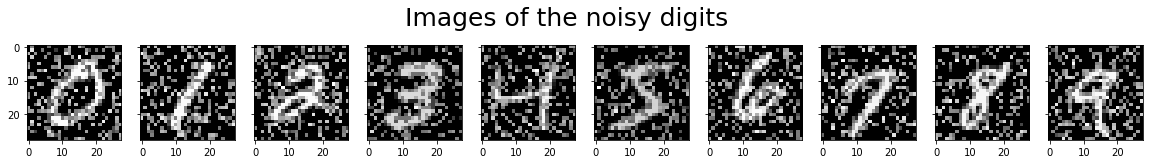

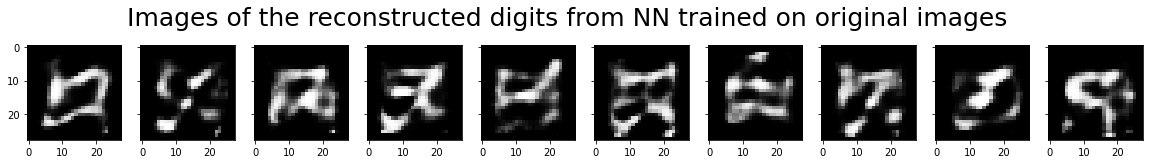

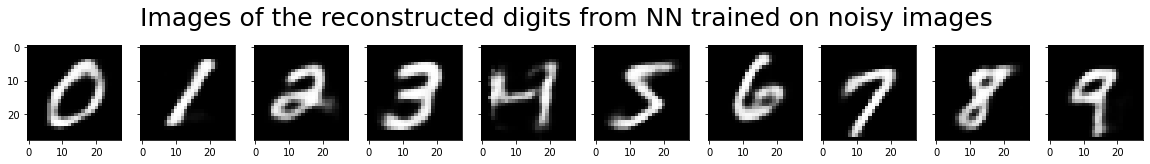

In [115]:
def free():
  #data
  classes = set(mnist_data.targets.numpy())
  test_examples_noised = [noised_mnist_data_test[np.where(mnist_targets_test == c)[0][0]].numpy() for c in classes]
  test_examples_noised = np.reshape(test_examples_noised, (len(test_examples_noised), 784))
  test_examples_predicted_complex = autoencoder_complex.predict(test_examples_noised)
  test_examples_predicted_complex_noised = autoencoder_complex_noised.predict(test_examples_noised)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the noisy digits', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_noised[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits from NN trained on original images', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_predicted_complex[i].reshape((28,28)), cmap=plt.cm.gray)

  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle('Images of the reconstructed digits from NN trained on noisy images', fontsize=25, y=1.1)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[ col].imshow(test_examples_predicted_complex_noised[i].reshape((28,28)), cmap=plt.cm.gray)

free()

I would think that it is a very very awful outcome, and therefore we can state that even if the model trained on noisy data has a bigger final loss (clearly since we are dealing with much more complicated pictures) than the other one, it generalizes the data far better.

### Conclusions

To summarize, let's test a final model, with even more depth, to see if we can get any better.

In [116]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
# This is the size of our encoded representations

autoencoder_deep_noised_augmented = Sequential([
    Input(shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(784, activation='sigmoid')
])
autoencoder_deep_noised_augmented.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', 
                        mode='min', 
                        patience = 8, 
                        verbose=1)

def train_autoencoder_deep_noised_augmented(): 
  noised_mnist_data_train_0 = _inject_noise(mnist_data_train, 0.0)
  noised_mnist_data_train_1 = _inject_noise(mnist_data_train, 0.1)
  noised_mnist_data_train_2 = _inject_noise(mnist_data_train, 0.2)
  noised_mnist_data_train_3 = _inject_noise(mnist_data_train, 0.3)
  noised_mnist_data_train_4 = _inject_noise(mnist_data_train, 0.4)
  noised_mnist_data_train_5 = _inject_noise(mnist_data_train, 0.5)
  noised_mnist_data_train_6 = _inject_noise(mnist_data_train, 0.6)
  noised_mnist_data_train_7 = _inject_noise(mnist_data_train, 0.7)

  noised_mnist_data_train_augemnted = np.concatenate((
      noised_mnist_data_train_0, 
      noised_mnist_data_train_1, 
      noised_mnist_data_train_2,
      noised_mnist_data_train_3,
      noised_mnist_data_train_4, 
      noised_mnist_data_train_5,
      noised_mnist_data_train_6, 
      noised_mnist_data_train_7
  ))
  targets_data_trans = np.concatenate((
      mnist_data_train, 
      mnist_data_train, 
      mnist_data_train,
      mnist_data_train,
      mnist_data_train, 
      mnist_data_train,
      mnist_data_train, 
      mnist_data_train
  ))

  noised_data_train_augemnted_trans = np.reshape(noised_mnist_data_train_augemnted, (len(noised_mnist_data_train_augemnted), 784))
  targets_data_trans = np.reshape(targets_data_trans, (len(targets_data_trans), 784))
  autoencoder_deep_noised_augmented.fit(noised_data_train_augemnted_trans, targets_data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder_deep_noised_augmented

autoencoder_deep_noised_augmented = getFromFileOrDefault('autoencoder_deep_noised_augmented', train_autoencoder_deep_noised_augmented)

After an hour and a half, the model should be trained on many copies of the data with varied degrees of noise, and now we can examine the result of the reconstruction at different levels (we will compare it to the "complex model" observed earlier trained on perturbed data).

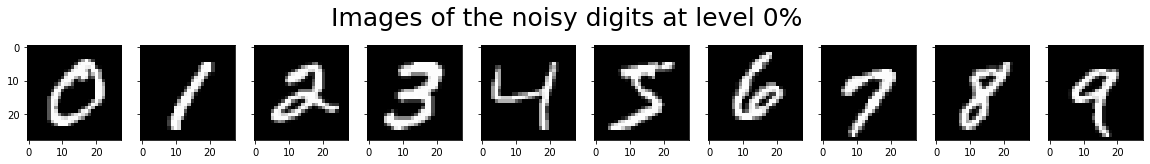

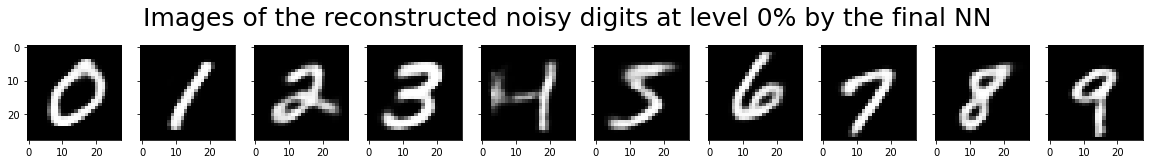

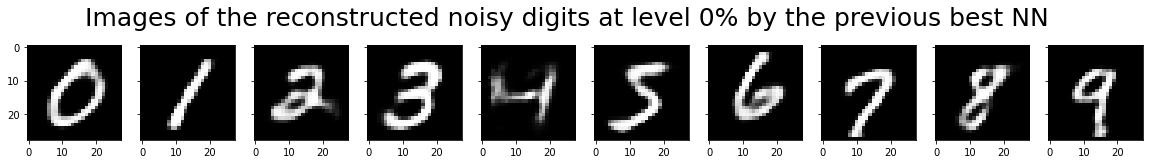

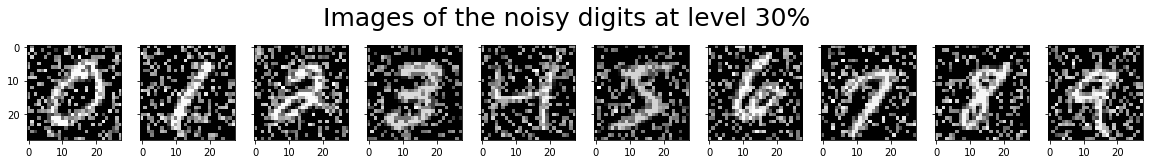

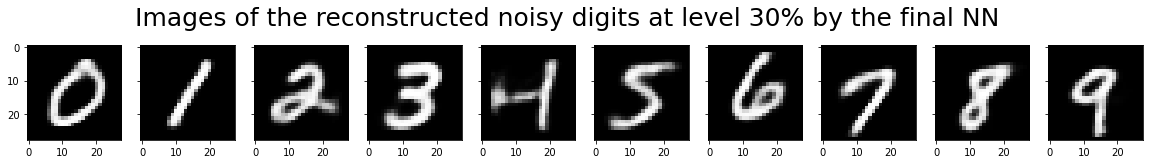

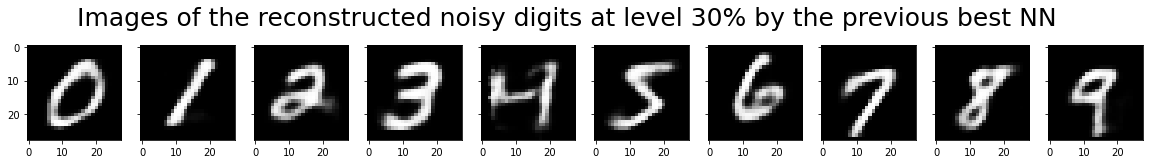

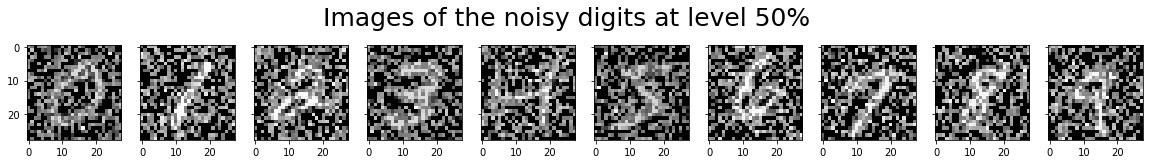

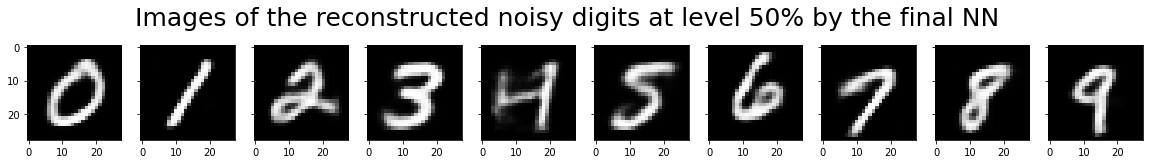

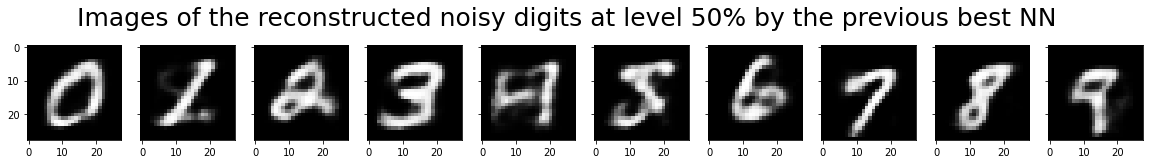

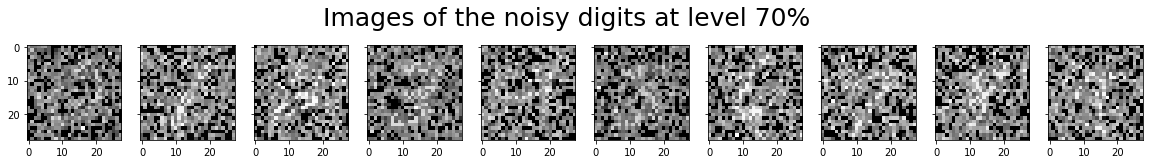

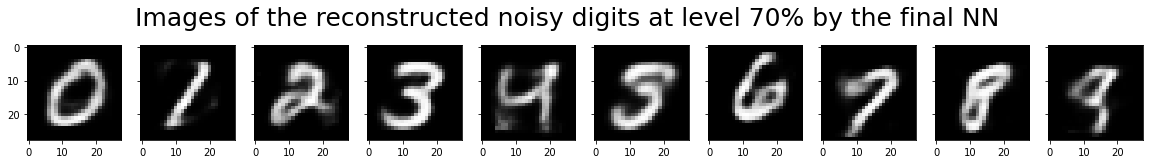

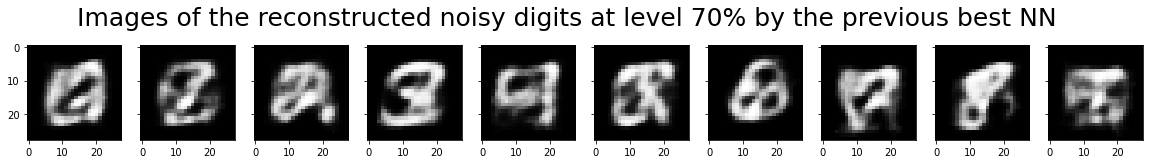

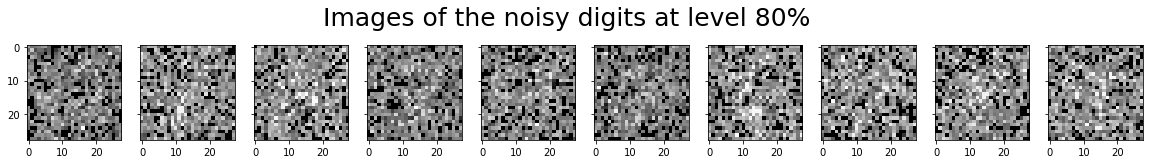

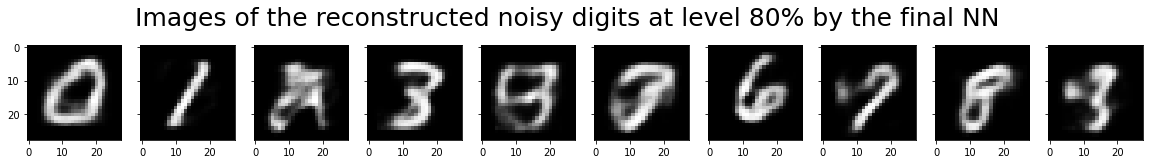

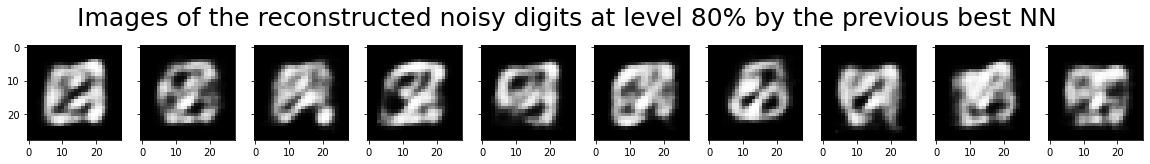

In [117]:
def free():
  for level in [0, 0.3, 0.5, 0.7, 0.8]:
    noisy_test_data = _inject_noise(mnist_data_test, level)
    very_noised_examples = np.reshape(noisy_test_data, (len(noisy_test_data), 784))
    very_noised_examples = np.array([very_noised_examples[np.where(mnist_targets_test == c)[0][0]].numpy() for c in classes])
    very_noised_examples = np.reshape(very_noised_examples, (len(very_noised_examples), 784))


    examples_predicted = autoencoder_deep_noised_augmented.predict(very_noised_examples)

    num_subplots = 10
    n_rows_cols = 1
    fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
    fig.suptitle(f"Images of the noisy digits at level {int(level*100)}%", fontsize=25, y=1.1)
    for i in range(num_subplots):
      row = i % n_rows_cols
      col = i // n_rows_cols
      axes[ col].imshow(very_noised_examples[i].reshape((28,28)), cmap=plt.cm.gray)
    num_subplots = 10
    n_rows_cols = 1
    fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
    fig.suptitle(f"Images of the reconstructed noisy digits at level {int(level*100)}% by the final NN", fontsize=25, y=1.1)
    for i in range(num_subplots):
      row = i % n_rows_cols
      col = i // n_rows_cols
      axes[ col].imshow(examples_predicted[i].reshape((28,28)), cmap=plt.cm.gray)

    test_examples_predicted_complex_noised = autoencoder_complex_noised.predict(very_noised_examples)
    num_subplots = 10
    n_rows_cols = 1
    fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
    fig.suptitle(f"Images of the reconstructed noisy digits at level {int(level*100)}% by the previous best NN", fontsize=25, y=1.1)
    for i in range(num_subplots):
      row = i % n_rows_cols
      col = i // n_rows_cols
      axes[ col].imshow(test_examples_predicted_complex_noised[i].reshape((28,28)), cmap=plt.cm.gray)


free()

We can clearly see that increasing the error, the previous model completely messes up the data, and so training the other model with different levels of noises allowed it to have an even better concept of noise at a higher percentege.


The figure also shows the reconstruction for 80% of the perturbation, which is not awful; some of the numerals are still identifiable.

We can also try feeding the autoencoder the picture that it has created as output to see if it helps to converge to a better final image.

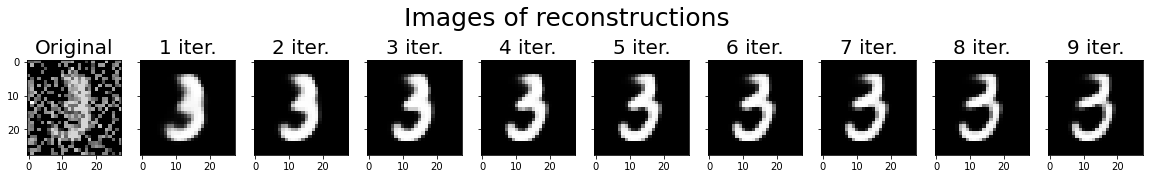

In [118]:
def free():
  classes = set(mnist_data.targets.numpy())
  test_example_noised = _inject_noise(mnist_data_test[10], 0.4).numpy()
  test_example_noised = np.reshape(test_example_noised, (1, 784))
  pred = [test_example_noised]
  
  for i in range(0, 10):
    pred.append(autoencoder_deep_noised_augmented.predict(pred[-1]))
  
  
  num_subplots = 10
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of reconstructions", fontsize=25, y=1.2)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    if i == 0:
      axes[ col].set_title("Original", fontsize=20)
    else:
      axes[ col].set_title(f"{i} iter.", fontsize=20)
    axes[ col].imshow(pred[i].reshape((28,28)), cmap=plt.cm.gray)

free()

Try with more steps:

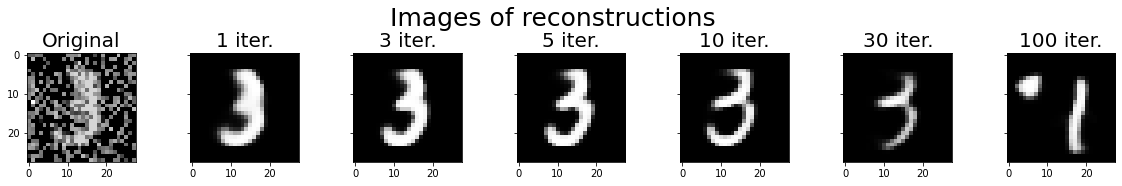

In [119]:
def free():
  classes = set(mnist_data.targets.numpy())
  test_example_noised = _inject_noise(mnist_data_test[10], 0.4).numpy()
  test_example_noised = np.reshape(test_example_noised, (1, 784))
  pred = [test_example_noised]
  
  for j in [1,3,5,10,30,100]:
    rec = test_example_noised
    for i in range(0, j):
      rec = autoencoder_deep_noised_augmented.predict(rec)
    pred.append(rec)
  
  
  num_subplots = 7
  n_rows_cols = 1
  fig, axes = plt.subplots(n_rows_cols, int(num_subplots/n_rows_cols), sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of reconstructions", fontsize=25, y=1.2)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    if i == 0:
      axes[ col].set_title("Original", fontsize=20)
    else:
      axes[ col].set_title(f"{[1,3,5,10,30,100][i-1]} iter.", fontsize=20)
    axes[ col].imshow(pred[i].reshape((28,28)), cmap=plt.cm.gray)

free()

### Final evaluation

Let us now attempt to establish a more formal method for calculating the accuracy of the reconstructions.

We have no major issues with the loss, and to keep things simple, we may compare the reconstruction's Mean Square Error to the original function.

I couldn't find a bounded accuracy measure to compute the error, so I suppose I'll have to come up with one on my own.  
Let we formulate the following accuracy:


$$
SingleAcc(prediction, target) = 1-\frac{\sum_{i=0}^{|prediction|}|prediction_i - target_i|}{\sum_{i=0}^{|target|}max(1-target_i\:,\: target_i)}\\[30pt]
FinalAcc(prediction, target) = \frac{\sum_{i=0}^{|predictions|}SingleAcc(predictions^{(i)}, targets^{(i)})}{|predictions|}
$$

Where: 
 - $SingleAcc$ takes a single prediction vector and a single target vector, and calculate the distance between the prediction and the target, and divide it by the highest error possible, which is the max between $1-target_i$ and $target_i$ (if we have a pixel with $0.2$ brightness, at most we can have a $0.8$ error)
 - $FinalAcc$ takes a vector of predictions and targets, and calculates the average error


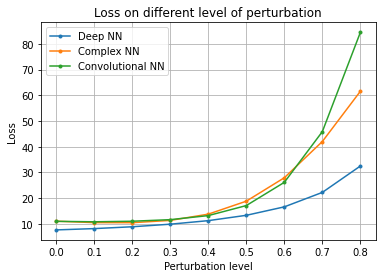

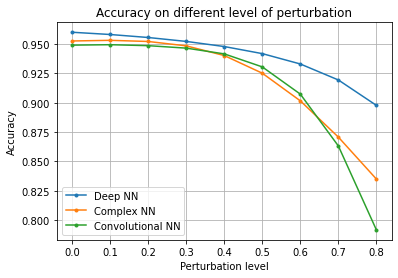

In [120]:
def mse(preds, targets):
  return np.sum((preds-targets)*(preds-targets))/len(targets)

def single_acc(pred, target):
  return 1-(np.abs(pred-target)/np.maximum(target, 1-target))
def final_acc(preds, targets):
  single_accs = [single_acc(pred, target) for (pred, target) in zip(preds, targets)] 
  return np.mean(single_accs)

def free():
  mses = {
      "deep" : [],
      'complex' : [], 
      'cnn' : [],
  }
  accs = {
      "deep" : [],
      'complex' : [], 
      'cnn' : [],
  }
  for level in np.linspace(0,0.8,9):
    test_trans_data = _inject_noise(mnist_data_test, level)
    targets = mnist_data_test.numpy().reshape((len(mnist_data_test), 784))


    predictions = autoencoder_deep_noised_augmented.predict(test_trans_data.numpy().reshape(len(mnist_data_test), 784))
    mses['deep'].append(mse(predictions, targets))
    accs['deep'].append(final_acc(predictions, targets))

    predictions = autoencoder_complex_noised.predict(test_trans_data.numpy().reshape(len(mnist_data_test), 784))
    mses['complex'].append(mse(predictions, targets))
    accs['complex'].append(final_acc(predictions, targets))

    predictions = autoencoder_cnn_noised.predict(test_trans_data.numpy())
    mses['cnn'].append(mse(predictions.reshape((len(predictions), 784)), targets))
    accs['cnn'].append(final_acc(predictions.reshape((len(predictions), 784)), targets))
  plt.plot(
    np.linspace(0,0.8,9),
    mses['deep'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    mses['complex'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    mses['cnn'],
    marker = 'o',
    markersize = 3
  )

  plt.title(f'Loss on different level of perturbation')
  plt.ylabel('Loss')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(['Deep NN', "Complex NN", "Convolutional NN"], loc = 'best')
  plt.show()




  plt.plot(
    np.linspace(0,0.8,9),
    accs['deep'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    accs['complex'],
    marker = 'o',
    markersize = 3
  )
  plt.plot(
    np.linspace(0,0.8,9),
    accs['cnn'],
    marker = 'o',
    markersize = 3
  )

  plt.title(f'Accuracy on different level of perturbation')
  plt.ylabel('Accuracy')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(['Deep NN', "Complex NN", "Convolutional NN"], loc = 'best')
  plt.show()

free()


This accuracy is rather unfair because the majority of each image is empty, and even if the model had created an empty image, the accuracy would have been good, but it's the best I could come up with.

However, the final Deep Neural Network, which was trained on more data with varying amounts of noise, definitely won.


Finally, let's check the precision of each digit to verify if they're all equally reconstructable.

In [121]:
digits_accs = {}
def free():
  for level in np.linspace(0,0.8,9):
    for c in set(mnist_targets_test.numpy()):
      if c not in digits_accs.keys():
        digits_accs[c] = []
      targets = mnist_data_test[np.where(mnist_targets_test == c)]
      test_trans_data = _inject_noise(targets, level).numpy()
      test_trans_data = test_trans_data.reshape((len(targets), 784))
      targets = targets.numpy().reshape((len(targets), 784))
      
      predictions = autoencoder_deep_noised_augmented.predict(test_trans_data)
      digits_accs[c].append(final_acc(predictions, targets))

free()

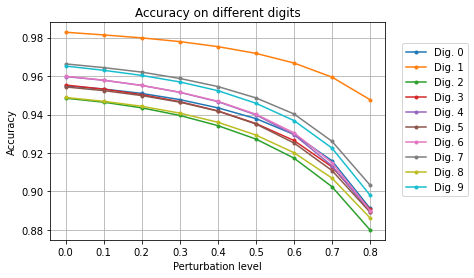

In [122]:
for d in digits_accs.values():
  plt.plot(
    np.linspace(0,0.8,9),
    d,
    marker = 'o',
    markersize = 3
  )

plt.title(f'Accuracy on different digits')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend([f"Dig. {i}" for i in range(0,10)], loc = (1.05,0.2))
plt.show()

As shown, not all numbers are equally easily reconstructable, but we will continue with this model because it is still working well. 

Check the accuracy with reconstruction:

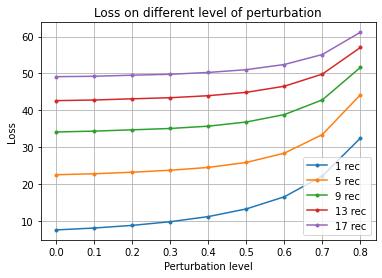

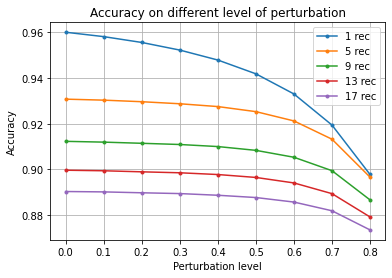

In [123]:

def free():
  mses = {}
  accs = {}
  for rec in range(1,20, 4):
    mses[f"{rec}"] = []
    accs[f"{rec}"] = []
    for level in np.linspace(0,0.8,9):
      test_trans_data = _inject_noise(mnist_data_test, level)
      test_trans_data = test_trans_data.reshape(len(test_trans_data), 784).numpy()
      targets = mnist_data_test.numpy().reshape((len(mnist_data_test), 784))
      predictions = test_trans_data
      for _ in range(0, rec):
        predictions = autoencoder_deep_noised_augmented.predict(predictions)
      mses[f"{rec}"].append(mse(predictions, targets))
      accs[f"{rec}"].append(final_acc(predictions, targets))

  leg = []
  for k,v in mses.items():
    leg.append(f"{k} rec")
    plt.plot(
      np.linspace(0,0.8,9),
      mses[k],
      marker = 'o',
      markersize = 3
    )

  plt.title(f'Loss on different level of perturbation')
  plt.ylabel('Loss')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(leg, loc = 'best')
  plt.show()


  leg = []
  for k,v in accs.items():
    leg.append(f"{k} rec")
    plt.plot(
      np.linspace(0,0.8,9),
      accs[k],
      marker = 'o',
      markersize = 3
    )

  plt.title(f'Accuracy on different level of perturbation')
  plt.ylabel('Accuracy')
  plt.xlabel('Perturbation level')
  plt.grid()
  plt.legend(leg, loc = 'best')
  plt.show()


free()

## Building the unsupervised model (DBN)

This section should be easy, as we may take inspiration from the code supplied for the laboratory.

### Import library

In [124]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [125]:
%%capture
get_dbn_library()

In [126]:
from DBN import DBN

At this stage, we must train the unsupervised model using the original data, and we will then utilize this model for both versions (with and without the autoencoder).



### Training

Start from the first one.

In [127]:
def train_dbn_from_original():
  dbn = DBN(visible_units=28*28,
      hidden_units=[500],
      k=1,
      learning_rate=0.1,
      learning_rate_decay=False,
      initial_momentum=0.5,
      final_momentum=0.9,
      weight_decay=0.0002,
      xavier_init=False,
      increase_to_cd_k=False,
      use_gpu=True)
  dbn.train_static(
      mnist_data_train,
      mnist_targets_train,
      500,
      1024
  )
  return dbn
dbn_from_original = getFromFileOrDefault("dbn_from_original", train_dbn_from_original)

Check the receptive fields of the DBN

In [128]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights, num_subplots = 100):
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  fig.suptitle(f"Filters for DBN", fontsize=25, y=0.95)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray) 

In [129]:
_move_parameters_to_cpu(dbn_from_original)

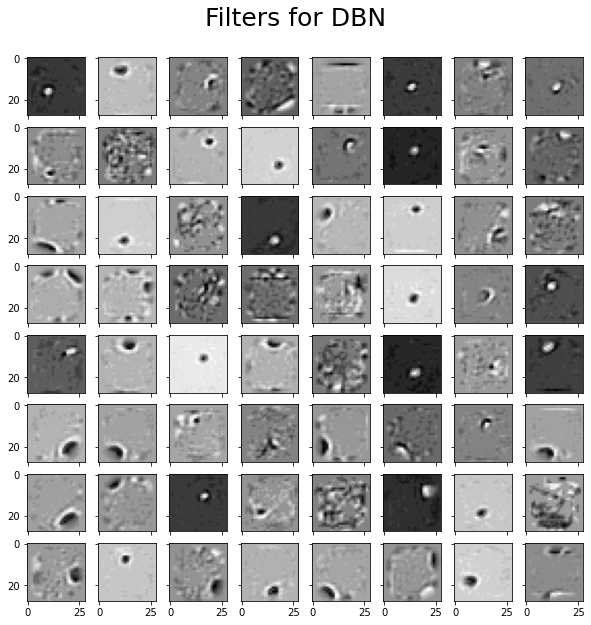

In [130]:
def free():
  learned_weights_layer_1 = dbn_from_original.rbm_layers[0].W.transpose(0,1).numpy()
  learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
  
  _plot_layer_receptive_fields(learned_weights_layer_1, num_subplots=64)

free()

We can still see that the concealed units are responding to certain locations on the photos, as predicted, and so they will fire only if a specific area of the image is "bright"

Let's create a dendogram to check how similar the digits for the DBN are.

In [131]:
def _get_last_layer_repr(input,):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_from_original.forward(flattened_input)  
  return hidden_repr

def _get_mask(label):  
  labels = mnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  
    for label in range(10)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  
    for label in range(10)])
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

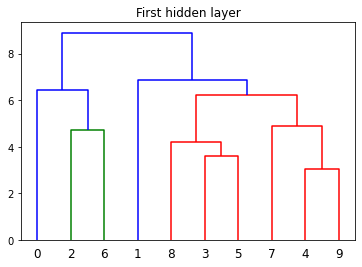

In [132]:
def free():
  outputs = _get_last_layer_repr(mnist_data_train)
  label_to_mean_hidd_repr = _get_label_to_mean_hidd_repr(outputs)
  mean_hidd_repr_matrix = _get_hidden_reprs_matrix(label_to_mean_hidd_repr)
  _plot_dendrogram(mean_hidd_repr_matrix, "First hidden layer")

free()

## Building the supervised model (Perceptron and NN)

During the course, we utilized DBN+Perceptron to obtain linear readouts from the final layer, which we would use as a benchmark.

On the other hand, we have the models that we created:
 1. Self-supervised Autoencoder
 2. The DBN. 

So, we can develop two final models to compare with the lab model:
 1. AE + DBN + Readout.
 2. AE + Readout
However, the AE autoencoder has no influence over how much the data is linearly separable, therefore we will use a little more complicated network to make the comparison fair.

Here are the last three models we'll test:
 1. DBN+Perceptron (Lab 1).
 2. AE + DBN + Perceptron. 
 3. AE + Deep Dense NN.

### DBN+Perceptron


In [133]:
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
def train_perceptron_for_dbn_lab():
  hidden_repr_layer_3_train = _get_last_layer_repr(mnist_data_train).numpy()

  perceptron_for_dbn_lab = Perceptron(tol=1e-3, random_state=0)
  perceptron_for_dbn_lab.fit(hidden_repr_layer_3_train, mnist_targets_train)
  return perceptron_for_dbn_lab

perceptron_for_dbn_lab = getFromFileOrDefault('perceptron_for_dbn_lab', train_perceptron_for_dbn_lab)

In [134]:
f"{perceptron_for_dbn_lab.score(_get_last_layer_repr(mnist_data_test).numpy(), mnist_targets_test)*100}% accuracy on test data"

'94.96% accuracy on test data'

Good result, on clean data

### AE+DBN+Perceptron

Now, we should figure out how to pass the result of the autoencoder to the DBN

In [135]:
def train_perceptron_for_dbn_autoencoder():
  predictions = autoencoder_deep_noised_augmented.predict(mnist_data_train.reshape((len(mnist_data_train), 784)).numpy())
  predictions = predictions.reshape(len(predictions), 28, 28)
  hidden_repr_layer_3_train = _get_last_layer_repr(torch.from_numpy(predictions)).numpy()

  perceptron_for_dbn_autoencoder = Perceptron(tol=1e-3, random_state=0)
  perceptron_for_dbn_autoencoder.fit(hidden_repr_layer_3_train, mnist_targets_train.numpy())
  return perceptron_for_dbn_autoencoder

perceptron_for_dbn_autoencoder = getFromFileOrDefault("perceptron_for_dbn_autoencoder", train_perceptron_for_dbn_autoencoder)


In [136]:
f"{perceptron_for_dbn_autoencoder.score(_get_last_layer_repr(mnist_data_test).numpy(), mnist_targets_test)*100}% accuracy on test data"

'91.49000000000001% accuracy on test data'

The accuracy is lower than just DBN+Perceptron, however this might be due to the loss of details/clear delimiters on the decoded pictures fed to the DBN (remember that the DBN is trained on the original data, not the modified one).

However, we are not here to discover the model that best matches the data, but rather the one that is most resilient to disturbances.


### AE+NN


So, let's train a deep dense NN to categorize the decoder outputs.

To be fair to the DBN, we will employ a NN with three layers of 500 neurons each, and a final softmax readout layer.

In [137]:
from tensorflow.keras.utils import to_categorical
def train_neural_network_for_autoencoder():
  inputs = autoencoder_deep_noised_augmented.predict(mnist_data_train.reshape((len(mnist_data_train), 784)).numpy())
  model = Sequential([
      Dense(input_dim = 784, units=500, activation='relu'),
      Dense(units=500, activation='relu'),
      Dense(units=500, activation='relu'),
      Dense(units=10, activation='softmax'),
  ])
  model.compile(loss='categorical_crossentropy', 
        optimizer='sgd',  
        metrics=['accuracy']) 

  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    patience = 8, 
                    verbose=1)
  model.fit(inputs, to_categorical(mnist_targets_train.numpy(), num_classes=10), epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return model

neural_network_for_autoencoder = getFromFileOrDefault('neural_network_for_autoencoder', train_neural_network_for_autoencoder)


In [138]:
from sklearn.metrics import accuracy_score
print(f"{accuracy_score(mnist_targets_test, np.argmax(neural_network_for_autoencoder.predict(autoencoder_deep_noised_augmented.predict(mnist_data_test.reshape((len(mnist_data_test), 784)).numpy())), axis=1)) *100}% accuracy on test data")

97.16% accuracy on test data


This outperforms DBN+Perceptron, maybe because to the ultimate deep NN, when compared to the autoencoder.

### AE + Perceptron


In [139]:
def train_perceptron_for_autoencoder():
  perceptron_for_autoencoder = Perceptron(tol=1e-3, random_state=0)
  perceptron_for_autoencoder.fit(mnist_data_train.reshape((len(mnist_data_train), 784)), mnist_targets_train)
  return perceptron_for_autoencoder

perceptron_for_autoencoder = getFromFileOrDefault("perceptron_for_autoencoder", train_perceptron_for_autoencoder)


In [140]:
!cp perceptron_for_autoencoder drive/MyDrive/CC/Models/perceptron_for_autoencoder

## Prepare model for the evaluation

### Preparation

We have arrived to the point that is the comparison between:
 - DBN+Perceptron
 - Autoencoder+NN
 - Autoencoder+DBN+Perceptron

compared on noisy data

In [141]:
# functions to get predictions
def pred_DBN_Perceptron(data, reconstructions=0):
  if data.shape != (len(data), 28, 28):
    data = data.reshape((len(data), 28, 28))
  for __ in range(0, reconstructions):
    data, __ = dbn_from_original.reconstruct(data)
  if torch.is_tensor(data) == False:
    data = torch.from_numpy(data)
  # compute the representation of the data on the last layer
  hidden_repr_layer_3_train = _get_last_layer_repr(data).numpy()
  # feed the predictions to the Perceptron
  return perceptron_for_dbn_lab.predict(hidden_repr_layer_3_train)

def pred_Autoencoder_Perceptron(data):
  if data.shape != (len(data), 784):
    data = data.reshape((len(data), 784))
  if isinstance(data, np.ndarray) == False:
    data = data.numpy()
  # compute the representation of the data on the last layer
  predictions = autoencoder_deep_noised_augmented.predict(data)
  # feed the predictions to the Perceptron
  return perceptron_for_autoencoder.predict(predictions)



def pred_Autoencoder_DBN_Perceptron(data, ae_reconstructions=0, dbn_reconstructions=0):
  if data.shape != (len(data), 784):
    data = data.reshape((len(data), 784))
  for __ in range(0, dbn_reconstructions):
    data, __ = dbn_from_original.reconstruct(data)
  if isinstance(data, np.ndarray) == False:
    data = data.numpy()
  # compute predictions for the autoencoder
  predictions = autoencoder_deep_noised_augmented.predict(data)
  for i in range(0, ae_reconstructions):
    predictions = autoencoder_deep_noised_augmented.predict(predictions)
  # reshape predictions for the DBN
  predictions = predictions.reshape(len(predictions), 28, 28)
  # compute the representation of the feeded predictions on the last layer
  hidden_repr_layer_3_train = _get_last_layer_repr(torch.from_numpy(predictions)).numpy()
  # feed the predictions to the Perceptron
  return perceptron_for_dbn_autoencoder.predict(hidden_repr_layer_3_train)


def pred_Autoencoder_NN(data, ae_reconstructions=0):
  if data.shape != (len(data), 784):
    data = data.reshape((len(data), 784))
  if isinstance(data, np.ndarray) == False:
    data = data.numpy()
  # compute predictions for the autoencoder
  predictions = autoencoder_deep_noised_augmented.predict(data)
  for i in range(0, ae_reconstructions):
    predictions = autoencoder_deep_noised_augmented.predict(predictions)
  # feed the predictions to the NN and find the argmax to know which digit is predicted
  return np.argmax(neural_network_for_autoencoder.predict(predictions), axis=1)



### Evaluation

Now we only need to produce some noisy data and observe how the various models react to it.

We will utilize _accuracy_ to evaluate performance, as the data is well balanced.

To be fair, during the course, we saw that DBN can reconstruct pictures, thus we will evaluate the precision using reconstructed photos.


In [142]:
accuracies = {
    'dbn_perceptron_0': [],
    'dbn_perceptron_1': [],
    'dbn_perceptron_2': [],
    'dbn_perceptron_3': [],
    'autoencoder_dbn_perceptron_0': [],
    'autoencoder_dbn_perceptron_1': [],
    'autoencoder_dbn_perceptron_2': [],
    'autoencoder_dbn_perceptron_3': [],
    'autoencoder_0_dbn_perceptron': [],
    'autoencoder_1_dbn_perceptron': [],
    'autoencoder_2_dbn_perceptron': [],
    'autoencoder_5_dbn_perceptron': [],
    'autoencoder_perceptron': [],
    'autoencoder_0_nn': [],
    'autoencoder_1_nn': [],
    'autoencoder_2_nn': [],
    'autoencoder_5_nn': []
}
def free():
  for level in np.linspace(0,0.9,10):
    noisy_test_data = _inject_noise(mnist_data_test, level)

    accuracies['dbn_perceptron_0'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=0), mnist_targets_test))
    accuracies['dbn_perceptron_1'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=1), mnist_targets_test))
    accuracies['dbn_perceptron_2'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=2), mnist_targets_test))
    accuracies['dbn_perceptron_3'].append(accuracy_score(pred_DBN_Perceptron(noisy_test_data, reconstructions=3), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_0'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=0), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_1'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=1), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_2'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=2), mnist_targets_test))
    accuracies['autoencoder_dbn_perceptron_3'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, dbn_reconstructions=3), mnist_targets_test))
    accuracies['autoencoder_0_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=0), mnist_targets_test))
    accuracies['autoencoder_1_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=1), mnist_targets_test))
    accuracies['autoencoder_2_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=2), mnist_targets_test))
    accuracies['autoencoder_5_dbn_perceptron'].append(accuracy_score(pred_Autoencoder_DBN_Perceptron(noisy_test_data, ae_reconstructions=5), mnist_targets_test))
    accuracies['autoencoder_perceptron'].append(accuracy_score(pred_Autoencoder_Perceptron(noisy_test_data), mnist_targets_test))
    accuracies['autoencoder_0_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=0), mnist_targets_test))
    accuracies['autoencoder_1_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=1), mnist_targets_test))
    accuracies['autoencoder_2_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=2), mnist_targets_test))
    accuracies['autoencoder_5_nn'].append(accuracy_score(pred_Autoencoder_NN(noisy_test_data, ae_reconstructions=5), mnist_targets_test))

free()

## Conclusions

### Accuracies with different noises

Now that we have the accuracies of the three models, we only need to evaluate how they behave to different amounts of noise and draw conclusions.

First, let's see the DBN+Perceptron with different reconstructions:

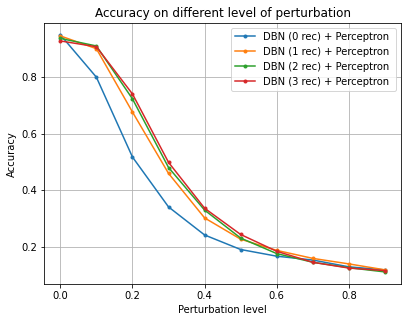

In [143]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_0'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_1'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_2'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_3'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['DBN (0 rec) + Perceptron ','DBN (1 rec) + Perceptron ','DBN (2 rec) + Perceptron ','DBN (3 rec) + Perceptron ', ], loc='best')
plt.show()

Let's now see the AE+DBN+Perc with different reconstructions (for DBN)

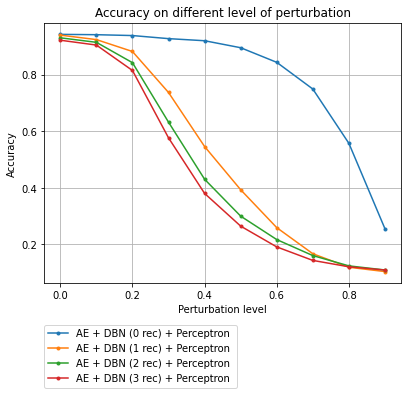

In [144]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_0'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_1'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_2'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_dbn_perceptron_3'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['AE + DBN (0 rec) + Perceptron ','AE + DBN (1 rec) + Perceptron ','AE + DBN (2 rec) + Perceptron ','AE + DBN (3 rec) + Perceptron ', ],  loc=(0,-0.4))
plt.show()

And now let's change the AE number of reconstructions (we won't change the DBN since we have seen that it just makes thing worse)

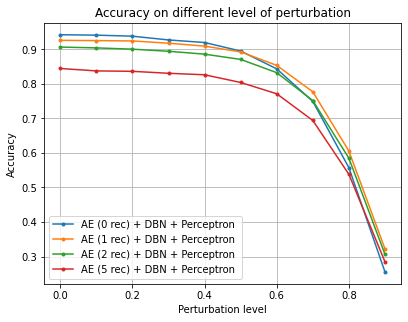

In [145]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_1_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_2_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_5_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['AE (0 rec) + DBN + Perceptron ','AE (1 rec) + DBN + Perceptron ','AE (2 rec) + DBN + Perceptron ','AE (5 rec) + DBN + Perceptron ', ], loc='best')
plt.show()

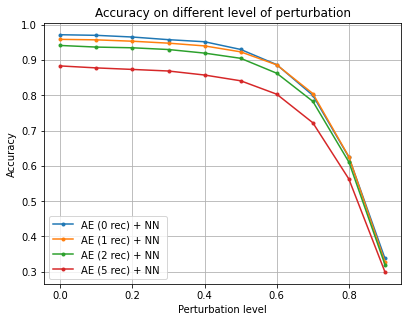

In [146]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_nn'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_1_nn'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_2_nn'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_5_nn'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['AE (0 rec) + NN ','AE (1 rec) + NN ','AE (2 rec) + NN ','AE (5 rec) + NN ', ], loc='best')
plt.show()

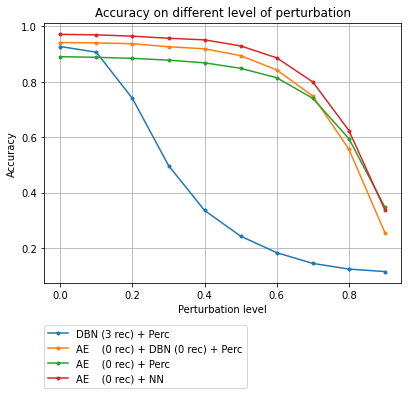

In [147]:

plt.plot(
  np.linspace(0,0.9,10),
  accuracies['dbn_perceptron_3'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_dbn_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_perceptron'],
  marker = 'o',
  markersize = 3
)
plt.plot(
  np.linspace(0,0.9,10),
  accuracies['autoencoder_0_nn'],
  marker = 'o',
  markersize = 3
)

plt.title(f'Accuracy on different level of perturbation')
plt.ylabel('Accuracy')
plt.xlabel('Perturbation level')
plt.grid()
plt.legend(['DBN (3 rec) + Perc', 'AE    (0 rec) + DBN (0 rec) + Perc', 'AE    (0 rec) + Perc', 'AE    (0 rec) + NN'], loc=(0,-0.4))
plt.show()

We see that the autoencoder clearly does an amazing job, but we can also see that given a reconstructed image using the autoencoder, the DBN (2 layers of 500 units) is almost as powerful as a fully connected neural network, with the advantage of the speed that it has in both training and predicting.

### Errors evaluation

Let's see what our model is actually missclassifying (we will consider noise at `0.5`)

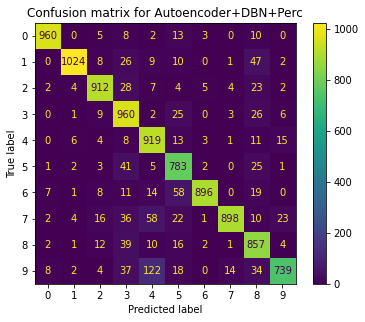

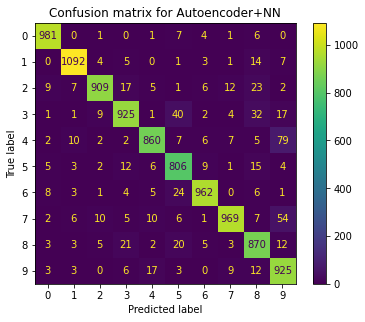

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json


def mat1():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)
  pred_ae_dbn_perc = pred_Autoencoder_DBN_Perceptron(noisy_test_data)
  cm = confusion_matrix(mnist_targets_test.numpy(), pred_ae_dbn_perc)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f'Confusion matrix for Autoencoder+DBN+Perc')
  plt.show()

def mat2():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)
  pred_ae_nn = pred_Autoencoder_NN(noisy_test_data)
  cm = confusion_matrix(mnist_targets_test.numpy(), pred_ae_nn)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f'Confusion matrix for Autoencoder+NN')
  plt.show()

mat1()
mat2()

For both of them, the biggest problem is the discrimination between $4$ and $9$, infact:
 - for AE+DBN+Perc a lot of $9$ were predicted as $4$
 - for AE+NN a lot of $4$ were predicted as 9

To undestarnd why, let's check some errors made by the models.

Starting from the AE+DBN+Perc:

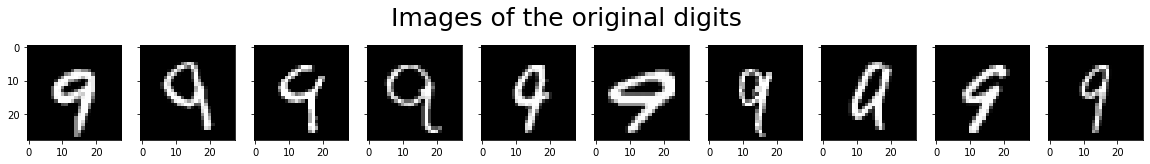

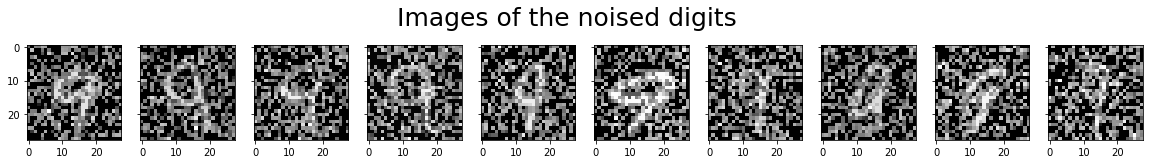

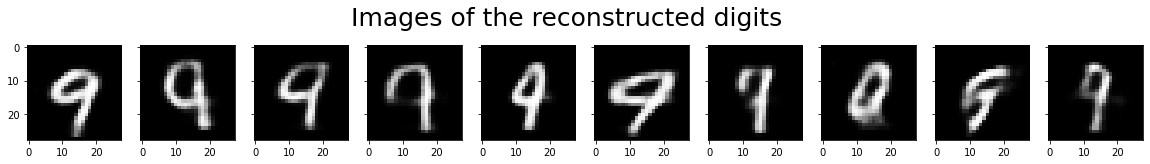

In [149]:
def free():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)

  #fetch data
  nines = mnist_data_test[
      np.intersect1d(
        np.where(mnist_targets_test == 9)[0], 
        np.where(pred_Autoencoder_DBN_Perceptron(_inject_noise(mnist_data_test, 0.5)) == 4))
      [0:10]]
  nines = nines.reshape((len(nines), 784))


  #inject noise
  nines_noised = _inject_noise(nines,0.5)
  nines_noised = nines_noised.reshape((len(nines_noised), 784))

  #denoise
  nines_denoised = autoencoder_deep_noised_augmented.predict(nines_noised.numpy())

  fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of the original digits", fontsize=25, y=1.1)
  for i in range(10):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[i].imshow(nines[i].reshape((28,28)), cmap=plt.cm.gray)
  fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of the noised digits", fontsize=25, y=1.1)
  for i in range(10):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[i].imshow(nines_noised[i].reshape((28,28)), cmap=plt.cm.gray)
  fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of the reconstructed digits", fontsize=25, y=1.1)
  for i in range(10):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[i].imshow(nines_denoised[i].reshape((28,28)), cmap=plt.cm.gray)

free()

These are the numbers 9 predicted by the AE+DBN+Perc as 4 (the highest item in the confusion matrix).  
What's most likely happening is that there are no more "clear traits" in some areas on the images after the denoising, and so, because the number 4 is a "more elastic" 9, not all features of those 9s are being captured by the DBN, and thus being exchanged by the perceptron as a 4 (and so it's like "taking out" some pieces from the 9, which probably becomes something like a 4).


Let's now do the same for the NN:

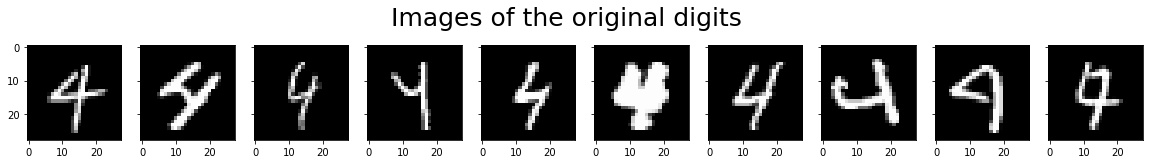

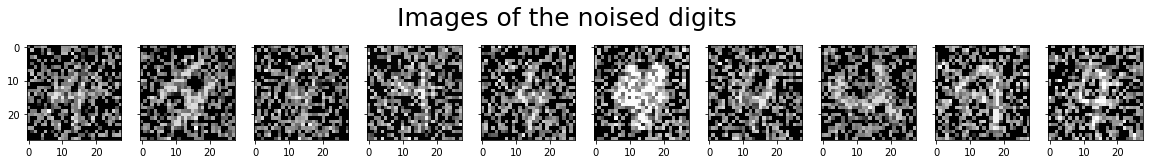

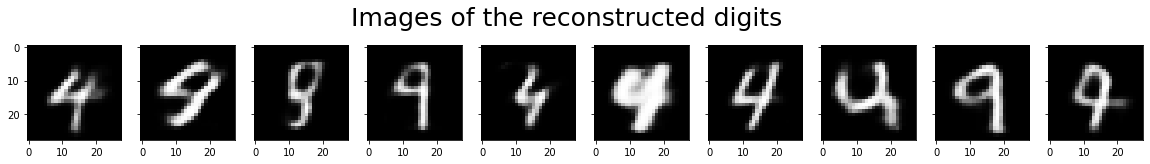

In [150]:
def free():
  noisy_test_data = _inject_noise(mnist_data_test, 0.5)

  #fetch data
  fours = mnist_data_test[
      np.intersect1d(
        np.where(mnist_targets_test == 4)[0], 
        np.where(pred_Autoencoder_NN(_inject_noise(mnist_data_test, 0.5)) == 9))
      [0:10]]
  fours = fours.reshape((len(fours), 784))


  #inject noise
  fours_noised = _inject_noise(fours,0.5)
  fours_noised = fours_noised.reshape((len(fours_noised), 784))

  #denoise
  fours_denoised = autoencoder_deep_noised_augmented.predict(fours_noised.numpy())


  fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of the original digits", fontsize=25, y=1.1)
  for i in range(10):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[i].imshow(fours[i].reshape((28,28)), cmap=plt.cm.gray)
  fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of the noised digits", fontsize=25, y=1.1)
  for i in range(10):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[i].imshow(fours_noised[i].reshape((28,28)), cmap=plt.cm.gray)
  fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(20, 2))
  fig.suptitle(f"Images of the reconstructed digits", fontsize=25, y=1.1)
  for i in range(10):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[i].imshow(fours_denoised[i].reshape((28,28)), cmap=plt.cm.gray)

free()

I believe the reason the NN is assessing those as 9 rather than 4 is that the digits were comparable to a 9 from the start, but the autoencoder, in an attempt to denoise the pictures, turned them into a 9. This is most likely due to the layer between the encoder and the decoder, which maps those samples far closer to the average latent space of 9 than to 4.  

This is further demonstrated by the fact that if we start with a very thin digit and add some noise on top of it, the noise may fill certain gaps, causing the noise to become part of the "thin digit" itself and no longer able to be reduced by the auto encoder.  
Furthermore, the main difference between the 4 and the 9 is the sharp angles, which the encoder removes by producing more "opaque" pictures.

All of this leads to the misclassification (although I would argue that some of those noised pictures may be identified by humans with more precision than those models have).

# Why autoencoder works

Autoencoders were chosen because they appeared to me to be a sort of "double", "self-supervised" DBN, in the sense that if we take a DBN and duplicate it starting from the last layer, we end up with a NN with symmetric structure in the middle layer.

Furthermore, having a connected intermediate layer required that those layers needed to acquire relevant characteristics from our inputs.

Finally, based on these observations, we may conclude that one "pass" in the autoencoder is equivalent to doing a whole picture reconstruction in a DBN (forward and back).

To compare those, we can take a look at the receptive fields of the 32 dimensions middle layer of the builded autoencoders, and considering all the points above, we should have similar receptive fields of the DBN



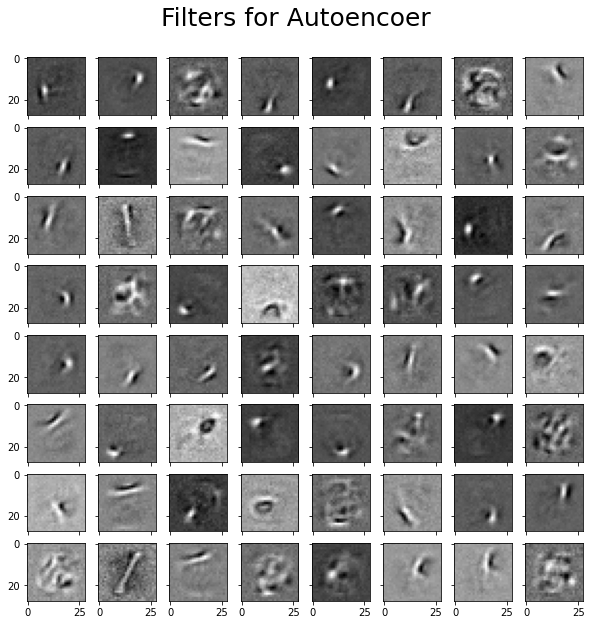

In [151]:
weights = np.array(autoencoder_deep_noised_augmented.layers[0].get_weights()[0]).T
n_rows_cols = 8

fig, axes = plt.subplots(n_rows_cols, 8, sharex=True, sharey=True, figsize=(10, 10))
fig.suptitle(f"Filters for Autoencoer", fontsize=25, y=0.95)
for i in range(64):
  row = i % n_rows_cols
  col = i // n_rows_cols
  axes[row, col].imshow(weights[i].reshape((28,28)), cmap=plt.cm.gray) 